<a href="https://colab.research.google.com/github/krishConqueror0609/Tinkers/blob/main/Tabnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.7 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.43764 | train_auc: 0.52056 | valid_auc: 0.55582 |  0:00:01s
epoch 1  | loss: 1.06177 | train_auc: 0.5588  | valid_auc: 0.55107 |  0:00:02s
epoch 2  | loss: 0.96053 | train_auc: 0.57766 | valid_auc: 0.53288 |  0:00:04s
epoch 3  | loss: 0.88429 | train_auc: 0.5825  | valid_auc: 0.54767 |  0:00:05s
epoch 4  | loss: 0.83444 | train_auc: 0.64006 | valid_auc: 0.59576 |  0:00:06s
epoch 5  | loss: 0.78458 | train_auc: 0.64198 | valid_auc: 0.59055 |  0:00:07s
epoch 6  | loss: 0.75909 | train_auc: 0.66019 | valid_auc: 0.56525 |  0:00:09s
epoch 7  | loss: 0.72087 | train_auc: 0.67171 | valid_auc: 0.58503 |  0:00:11s
epoch 8  | loss: 0.70812 | train_auc: 0.67744 | valid_auc: 0.63746 |  0:00:12s
epoch 9  | loss: 0.71312 | train_auc: 0.69083 | valid_auc: 0.6388  |  0:00:13s
epoch 10 | loss: 0.69039 | train_auc: 0.68167 | valid_auc: 0.65513 |  0:00:15s
epoch 11 | loss: 0.67534 | train_auc: 0.70844 | valid_auc: 0.66617 |  0:00:16s
epoch 12 | loss: 0.66344 | train_auc: 0.71343 | vali

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Test Accuracy: 0.8047

Classification Report:
                precision    recall  f1-score   support

No Alzheimer's       0.82      0.89      0.85       277
   Alzheimer's       0.76      0.65      0.70       153

      accuracy                           0.80       430
     macro avg       0.79      0.77      0.78       430
  weighted avg       0.80      0.80      0.80       430



<Figure size 800x600 with 0 Axes>

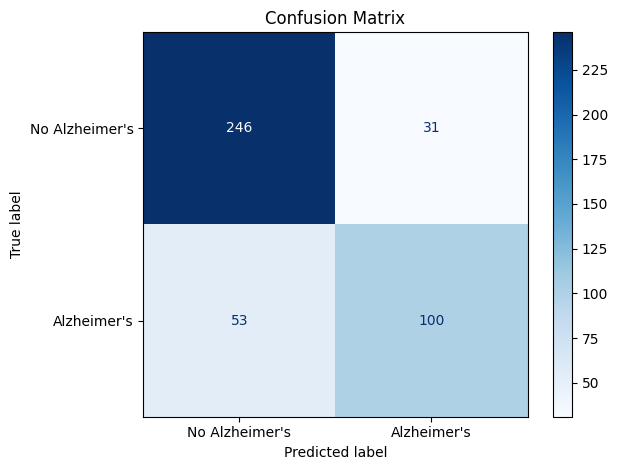

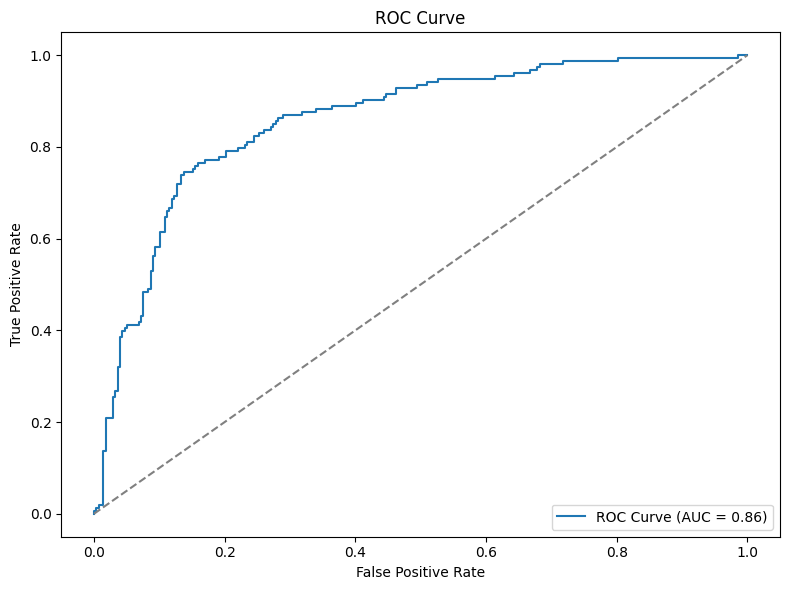

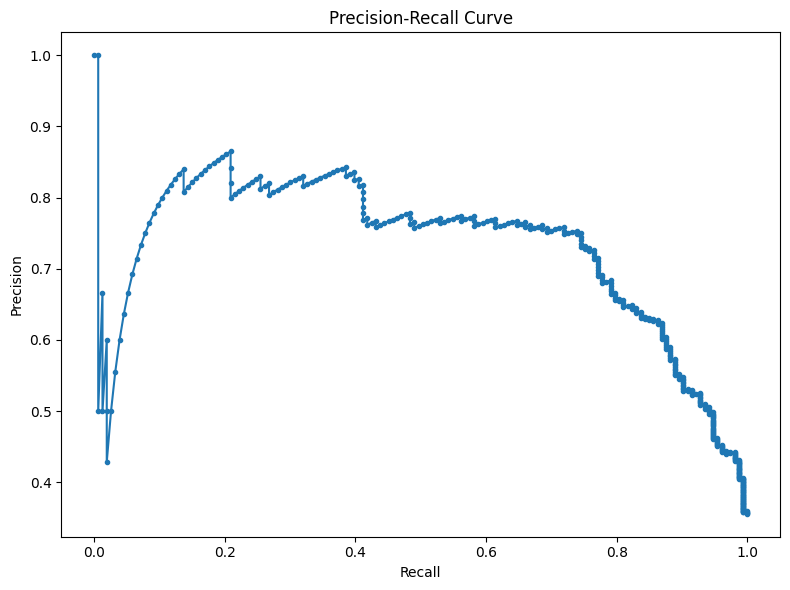

  0%|          | 0/100 [00:00<?, ?it/s]

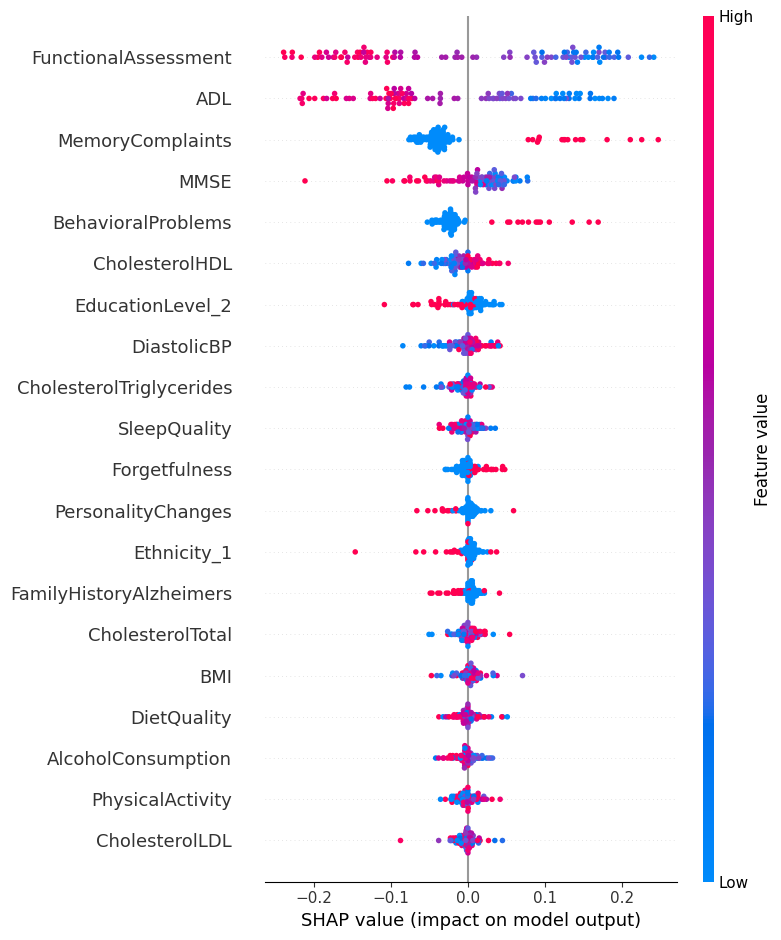

<Figure size 640x480 with 0 Axes>

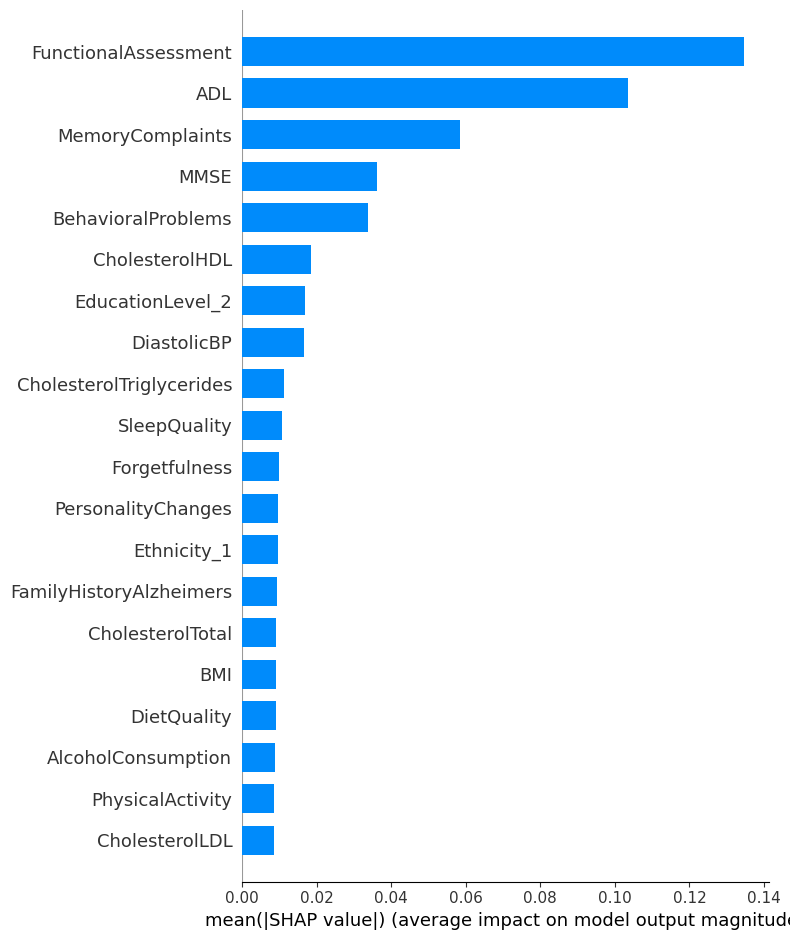

<Figure size 640x480 with 0 Axes>

In [ ]:
!pip install pytorch-tabnet shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report
from sklearn.preprocessing import StandardScaler
import shap
from pytorch_tabnet.tab_model import TabNetClassifier

# Load the preprocessed dataset
file_path = 'processed_alzheimers.csv'  # Replace with your file path
data = pd.read_csv("/content/processed_alzehaimers.csv")

# Split the dataset
X = data.drop(columns=['Diagnosis_1'])  # Features
y = data['Diagnosis_1']  # Target

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = X_train.astype(np.float32)
X_test_tensor = X_test.astype(np.float32)
y_train_tensor = y_train.values.astype(np.int64)
y_test_tensor = y_test.values.astype(np.int64)

# Initialize TabNet Classifier
tabnet_model = TabNetClassifier(
    n_d=64,  # Feature Transformer Dimension
    n_a=64,  # Attention Transformer Dimension
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    lambda_sparse=0.001,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-3),
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params=dict(step_size=10, gamma=0.9),
    mask_type='entmax'
)

# Train the model
tabnet_model.fit(
    X_train_tensor, y_train_tensor,
    eval_set=[(X_train_tensor, y_train_tensor), (X_test_tensor, y_test_tensor)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=100,
    patience=15,
    batch_size=128,
    virtual_batch_size=32
)

# Generate predictions
predictions = tabnet_model.predict(X_test_tensor)
probabilities = tabnet_model.predict_proba(X_test_tensor)[:, 1]

# Calculate and print accuracy and classification report
accuracy = (predictions == y_test_tensor).mean()
print(f"Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_tensor, predictions, target_names=["No Alzheimer's", "Alzheimer's"]))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_tensor, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Alzheimer's", "Alzheimer's"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Plot ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test_tensor, probabilities)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
precision, recall, thresholds = precision_recall_curve(y_test_tensor, probabilities)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision-Recall Curve")
plt.tight_layout()
plt.show()

# SHAP Analysis
# Convert data to numpy for SHAP
X_background = X_train_tensor[:100]  # Use subset of training data as background

# Create SHAP explainer
explainer = shap.KernelExplainer(
    lambda x: tabnet_model.predict_proba(x)[:, 1],
    X_background
)

# Calculate SHAP values for a subset of test data
shap_values = explainer.shap_values(X_test_tensor[:100])

# SHAP Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_tensor[:100],
                 feature_names=data.drop(columns=['Diagnosis_1']).columns)
plt.tight_layout()
plt.show()

# SHAP Bar Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_tensor[:100],
                 feature_names=data.drop(columns=['Diagnosis_1']).columns,
                 plot_type='bar')
plt.tight_layout()
plt.show()
